#  <span style='color:blue'> **VEHICLE CO<sub>2</sub> EMISSION PREDICTION**

This notebook implements a predictive model for Vehicle CO<sub>2</sub> Emissions using machine learning techniques. The notebook explores the relationships between various vehicle features (e.g., engine size, fuel type, transmission type) and CO₂ emissions and evaluates multiple machine learning techniques on the problem to pick the most accurate model.


***Importing required libraries***

In [1]:
import os
import joblib
import json
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from warnings import filterwarnings

filterwarnings('ignore')

***Loading the data and dropping unwanted columns. Also renaming columns to easier names***

In [2]:
data = pd.read_csv('./dataset/car_emissions.csv')

In [3]:
df1 = data.drop(['Model','Fuel Consumption City (L/100 km)', 'Fuel Consumption Hwy (L/100 km)', 'Fuel Consumption Comb (mpg)'],axis='columns')
df1.rename({
    'Make':'Make',
    'Vehicle Class': 'Vehicle_Class',
    'Engine Size(L)': 'Engine_Size',
    'Cylinders':'Cylinders',
    'Transmission':'Transmission',
    'Fuel Type':'Fuel_Type',
    'Fuel Consumption Comb (L/100 km)': 'Fuel_Consumption',	
    'CO2 Emissions(g/km)' : 'CO2_Emissions'
},inplace=True,axis='columns')
df1.head(10)

,Make,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Type,Fuel_Consumption,CO2_Emissions
0,ACURA,COMPACT,2.0,4,AS5,Z,8.5,196
1,ACURA,COMPACT,2.4,4,M6,Z,9.6,221
2,ACURA,COMPACT,1.5,4,AV7,Z,5.9,136
3,ACURA,SUV - SMALL,3.5,6,AS6,Z,11.1,255
4,ACURA,SUV - SMALL,3.5,6,AS6,Z,10.6,244
5,ACURA,MID-SIZE,3.5,6,AS6,Z,10.0,230
6,ACURA,MID-SIZE,3.5,6,AS6,Z,10.1,232
7,ACURA,MID-SIZE,3.7,6,AS6,Z,11.1,255
8,ACURA,MID-SIZE,3.7,6,M6,Z,11.6,267
9,ACURA,COMPACT,2.4,4,AS5,Z,9.2,212


***Creating an "others" category for manufacturers that have less than 40 entries in the dataset***

In [4]:
others = np.array((df1['Make'].value_counts() < 40).sort_index())
models = sorted(list(np.array(df1['Make'].unique())))
models = np.vstack([models,others]).T
other_models = pd.DataFrame(models,columns=['models','others_group'])


df1['Make'] = df1['Make'].apply(
    lambda x: x if other_models[other_models['models'] == x]['others_group'].values == 'False' else 'OTHERS'
)

***Separating the gear count and transmission type from the Transmission column***

In [5]:
def extract_gear(trans,index):
    transmission = ''
    gear = ''
    for x in trans:
        if x.isdigit():
            gear += x
        else:
            transmission += x
    if transmission == 'AV':
        gear = "0"
    if index == 1:
        return int(gear)
    elif index == 0:
        return transmission

df1['Gear'] = df1['Transmission'].apply(lambda x: extract_gear(x,1))
df1['Transmission'] = df1['Transmission'].apply(lambda x: extract_gear(x,0))

***Defining column types***

In [6]:
numerical_columns = ['Engine_Size','Fuel_Consumption','Gear']
categorical_columns = ['Make','Vehicle_Class','Cylinders','Transmission','Fuel_Type']
target_column = ['CO2_Emissions']

assert(len(numerical_columns)+len(categorical_columns)+len(target_column)==len(df1.columns))

***Exploring the relationship between each categorical feature and CO<sub>2</sub> emission***

In [7]:
pd.DataFrame(df1.groupby(['Make'])
             .aggregate('mean', 'CO2_Emissions')
             .sort_values('CO2_Emissions',ascending=False)['CO2_Emissions'])

,CO2_Emissions
Make,
LAMBORGHINI,400.780488
ROLLS-ROYCE,388.480000
BENTLEY,362.934783
ASTON MARTIN,339.617021
MASERATI,318.147541
GMC,299.917683
RAM,292.402062
LAND ROVER,287.647059
MERCEDES-BENZ,277.386635


In [8]:
pd.DataFrame(df1.groupby(['Vehicle_Class'])
             .aggregate('mean', 'CO2_Emissions')
             .sort_values('CO2_Emissions',ascending=False)['CO2_Emissions'])

,CO2_Emissions
Vehicle_Class,
VAN - PASSENGER,397.212121
VAN - CARGO,361.500000
SUV - STANDARD,304.836735
PICKUP TRUCK - STANDARD,301.513011
PICKUP TRUCK - SMALL,278.968553
TWO-SEATER,277.454348
FULL-SIZE,263.316119
MINIVAN,262.312500
SUBCOMPACT,246.448845


In [9]:
pd.DataFrame(df1.groupby(['Cylinders'])
             .aggregate('mean', 'CO2_Emissions')
             .sort_values('CO2_Emissions',ascending=False)['CO2_Emissions'])

,CO2_Emissions
Cylinders,
16,522.000000
12,381.033113
10,361.309524
8,320.619116
6,263.446852
5,235.692308
4,204.859938
3,174.894737


In [10]:
pd.DataFrame(df1.groupby(['Transmission'])
             .aggregate('mean', 'CO2_Emissions')
             .sort_values('CO2_Emissions',ascending=False)['CO2_Emissions'])

,CO2_Emissions
Transmission,
A,277.621826
AS,255.392709
AM,249.727554
M,228.345992
AV,184.310764


In [11]:
pd.DataFrame(df1.groupby(['Fuel_Type'])
             .aggregate('mean', 'CO2_Emissions')
             .sort_values('CO2_Emissions',ascending=False)['CO2_Emissions'])

,CO2_Emissions
Fuel_Type,
E,275.091892
Z,266.043410
D,237.548571
X,235.119329
N,213.000000


***Exploring the relationship between each numerical feature and CO<sub>2</sub> emission***

In [12]:
pd.DataFrame(df1[numerical_columns+target_column].corr()['CO2_Emissions']).reset_index().rename({
                                                                                                'index':'Feature',
                                                                                                'CO2_Emissions':'CO2_Correlation'},axis='columns')

,Feature,CO2_Correlation
0,Engine_Size,0.851145
1,Fuel_Consumption,0.918052
2,Gear,0.358927
3,CO2_Emissions,1.000000


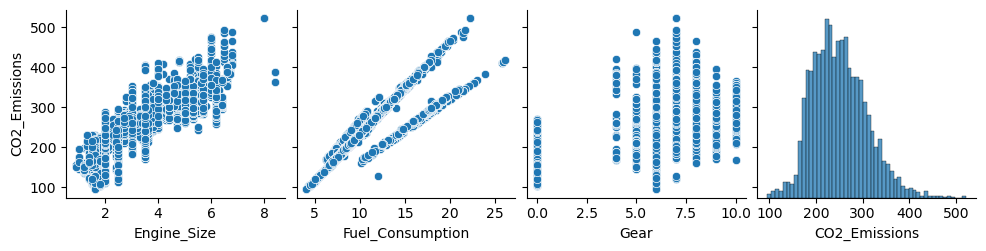

In [13]:
sn.pairplot(df1[numerical_columns+target_column],y_vars=target_column)
plt.show()

***Separating the target column and one hot encoding the categorical features***

In [14]:
features = pd.get_dummies(df1.drop(target_column, axis='columns'),columns=categorical_columns,dtype=int,prefix="",prefix_sep="")
label = df1[target_column]

assert(df1[categorical_columns].nunique().sum()+len(numerical_columns) == len(features.columns))

***Splitting the data into train and test sets***

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, label, random_state=7, train_size=0.9)

***Defining the search space for the models and their hyperparameter***

In [16]:
model_config = {



    'gradient_boost': {
        'model': GradientBoostingRegressor(),
        'params': {
            'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
            'learning_rate': [1e-1,1e-2,1e-3],
            'n_estimators': list(range(50,200,50)),
            'criterion': ['friedman_mse', 'squared_error']
        }
    },



    'random_forest': {
        'model': RandomForestRegressor(n_estimators=50),
        'params': {
            'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

        }
    },



    'l1_linear': {
        'model': Lasso(),
        'params': {
            'alpha': list(np.linspace(1,3,5)),
            'selection': ['cyclic', 'random']
        }
    },



    'l2_linear': {
        'model': Ridge(),
        'params': {
            'alpha': list(np.linspace(1,3,5)),
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
        }
    },



    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"]        }
    },



    'k_neighbors': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': list(range(5,15,3)),
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        }
    },


}

***Using GridSearch to find the best model and hyperparameters***

In [17]:
scores = []

for model_name, model_params in model_config.items():
    gcv = GridSearchCV(model_params['model'],model_params['params'],cv=10,return_train_score=False)
    gcv.fit(X_train,y_train)
    scores.append({
        'model_name': model_name,
        'best_params': gcv.best_params_,
        'best_score': gcv.best_score_,
        'best_model': gcv.best_estimator_,
        'best_mae': mean_absolute_error(y_test,gcv.best_estimator_.predict(X_test)),
        'best_rmse': root_mean_squared_error(y_test,gcv.best_estimator_.predict(X_test))
    })

In [18]:
scores_df = pd.DataFrame(scores).sort_values(ascending=True, by=['best_rmse','best_mae'],ignore_index=True)
scores_df

,model_name,best_params,best_score,best_model,best_mae,best_rmse
0,random_forest,{'criterion': 'squared_error'},0.997390,"(DecisionTreeRegressor(max_features=1.0, rando...",1.757361,2.709637
1,gradient_boost,"{'criterion': 'squared_error', 'learning_rate'...",0.996824,"([DecisionTreeRegressor(max_depth=3,\n ...",2.243125,2.954657
2,decision_tree,{'criterion': 'squared_error'},0.996939,DecisionTreeRegressor(),1.805671,3.142542
3,k_neighbors,"{'algorithm': 'kd_tree', 'n_neighbors': 8, 'we...",0.991869,"KNeighborsRegressor(algorithm='kd_tree', n_nei...",2.779369,4.795857
4,l2_linear,"{'alpha': 1.0, 'solver': 'lsqr'}",0.992457,Ridge(solver='lsqr'),2.984349,5.248303
5,l1_linear,"{'alpha': 1.0, 'selection': 'cyclic'}",0.976354,Lasso(),5.696689,8.840668


***Getting the best model***

In [19]:
model = scores_df.loc[0]['best_model']

***Testing the model***

In [20]:
def predict(model,Make, Vehicle_Class, Engine_Size, Cylinders, Transmission,
       Fuel_Type, Fuel_Consumption, Gear):
    columns = list(features.columns)
    inp = np.zeros([1,len(list(features.columns))])

    inp[:,0] = Engine_Size
    inp[:,1] = Fuel_Consumption
    inp[:,2] = Gear

    inp[:,columns.index(Make)] = 1
    inp[:,columns.index(Vehicle_Class)] = 1
    inp[:,columns.index(Cylinders)] = 1
    inp[:,columns.index(Transmission)] = 1
    inp[:,columns.index(Fuel_Type)] = 1


    return model.predict(inp)[0]

In [21]:
df1.sample(1,random_state=22)

,Make,Vehicle_Class,Engine_Size,Cylinders,Transmission,Fuel_Type,Fuel_Consumption,CO2_Emissions,Gear
4496,BMW,SUV - SMALL,2.0,4,AS,Z,9.3,217,8


In [22]:
pred = predict(model,
               Make='BMW',
               Vehicle_Class='SUV - SMALL',
               Engine_Size=2.0,
               Cylinders='4',
               Transmission='AS',
               Fuel_Type='Z',
               Fuel_Consumption=9.3,
               Gear=8)

print('Actual CO\u2082 emission is 217')
print(f'Predicted CO\u2082 emission is {pred}')

Actual CO₂ emission is 217
Predicted CO₂ emission is 217.08


***Saving the model***

In [23]:
file_path = './model.joblib'

if os.path.exists(file_path):
    os.remove(file_path)

joblib.dump(model,'./model.joblib')

['./model.joblib']

***Saving the columns as the arrangement is very important***

In [24]:
file_path = './input_columns.json'

if os.path.exists(file_path):
    os.remove(file_path)

input_columns = {
    'input_columns': list(features.columns)
}

with open(file_path,'w') as f:
    json.dump(input_columns,f)